In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from collections import OrderedDict as odict
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

from utils import ssv
from generator import Generator
from torchsummaryX import summary
from clevr_dataset import CLEVRDataset, collate_fn
from ssv import VPNet, VPAwareSynthesizer

import matplotlib.pyplot as plt

In [3]:
import torchvision as tv

def to_pil_grid(batch):
    return tv.transforms.functional.to_pil_image(tv.utils.make_grid(batch))

In [19]:
p = torch.tensor([0.5], requires_grad=True)

In [22]:
p, p.grad

(tensor([0.5000], requires_grad=True), None)

In [26]:
p_hard = ssv.st_trick(p)
p_hard, p_hard.grad

(tensor([1.], grad_fn=<AddBackward0>), None)

In [27]:
p_hard.sum().backward()

In [28]:
p_hard, p_hard.grad, p, p.grad

(tensor([1.], grad_fn=<AddBackward0>),
 None,
 tensor([0.5000], requires_grad=True),
 tensor([1.]))

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
%%time
dataset = CLEVRDataset('/storage1/datasets/CLEVR_v1.0/', 'train', image_sizes=((128, 128),))

CPU times: user 11.1 s, sys: 1.44 s, total: 12.5 s
Wall time: 12.5 s


In [6]:
vpnet = VPNet(instance_norm=True).cuda()
summary(vpnet, torch.randn(1, 3, 128, 128).cuda())

                                       Kernel Shape        Output Shape  \
Layer                                                                     
0_from_rgb.Conv2d_conv                            -   [1, 64, 128, 128]   
1_progression.0.conv.0.Conv2d_conv                -  [1, 128, 128, 128]   
2_progression.0.conv.InstanceNorm2d_1             -  [1, 128, 128, 128]   
3_progression.0.conv.LeakyReLU_2                  -  [1, 128, 128, 128]   
4_progression.0.conv.3.Conv2d_conv                -  [1, 128, 128, 128]   
5_progression.0.conv.InstanceNorm2d_4             -  [1, 128, 128, 128]   
6_progression.0.conv.LeakyReLU_5                  -  [1, 128, 128, 128]   
7_progression.1.conv.0.Conv2d_conv                -    [1, 128, 64, 64]   
8_progression.1.conv.InstanceNorm2d_1             -    [1, 128, 64, 64]   
9_progression.1.conv.LeakyReLU_2                  -    [1, 128, 64, 64]   
10_progression.1.conv.3.Conv2d_conv               -    [1, 128, 64, 64]   
11_progression.1.conv.Ins

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_from_rgb.Conv2d_conv,-,"[1, 64, 128, 128]",384.0,320.0
1_progression.0.conv.0.Conv2d_conv,-,"[1, 128, 128, 128]",73856.0,73728.0
2_progression.0.conv.InstanceNorm2d_1,-,"[1, 128, 128, 128]",NaN,NaN
3_progression.0.conv.LeakyReLU_2,-,"[1, 128, 128, 128]",NaN,NaN
4_progression.0.conv.3.Conv2d_conv,-,"[1, 128, 128, 128]",147584.0,147456.0
5_progression.0.conv.InstanceNorm2d_4,-,"[1, 128, 128, 128]",NaN,NaN
6_progression.0.conv.LeakyReLU_5,-,"[1, 128, 128, 128]",NaN,NaN
7_progression.1.conv.0.Conv2d_conv,-,"[1, 128, 64, 64]",147584.0,147456.0
8_progression.1.conv.InstanceNorm2d_1,-,"[1, 128, 64, 64]",NaN,NaN


In [7]:
generator = Generator().cuda()
z_bg = torch.randn(1, 1, 32).cuda()
z_fg = torch.randn(1, 1, 64).cuda()
view_bg = None
view_fg = torch.rand(1, 9).cuda()
summary(generator, z_bg, z_fg, view_bg, view_fg)

                                                         Kernel Shape  \
Layer                                                                   
0_bg_generator.adain0.Linear_z_proj                         [32, 512]   
1_bg_generator.adain0.ReLU_relu                                     -   
2_bg_generator.adain0.InstanceNorm3d_ins_norm                       -   
3_bg_generator.LeakyReLU_lrelu                                      -   
4_bg_generator.deconvs.ConvTranspose3d_0          [128, 256, 3, 3, 3]   
5_bg_generator.adains.0.Linear_z_proj                       [32, 256]   
6_bg_generator.adains.0.ReLU_relu                                   -   
7_bg_generator.adains.0.InstanceNorm3d_ins_norm                     -   
8_bg_generator.LeakyReLU_lrelu                                      -   
9_bg_generator.deconvs.ConvTranspose3d_1           [64, 128, 3, 3, 3]   
10_bg_generator.adains.1.Linear_z_proj                      [32, 128]   
11_bg_generator.adains.1.ReLU_relu                 

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_bg_generator.adain0.Linear_z_proj,"[32, 512]","[1, 512]",16896.0,16384.0
1_bg_generator.adain0.ReLU_relu,-,"[1, 512]",NaN,NaN
2_bg_generator.adain0.InstanceNorm3d_ins_norm,-,"[1, 256, 4, 4, 4]",NaN,NaN
3_bg_generator.LeakyReLU_lrelu,-,"[1, 256, 4, 4, 4]",NaN,NaN
4_bg_generator.deconvs.ConvTranspose3d_0,"[128, 256, 3, 3, 3]","[1, 128, 8, 8, 8]",884864.0,452984832.0
5_bg_generator.adains.0.Linear_z_proj,"[32, 256]","[1, 256]",8448.0,8192.0
6_bg_generator.adains.0.ReLU_relu,-,"[1, 256]",NaN,NaN
7_bg_generator.adains.0.InstanceNorm3d_ins_norm,-,"[1, 128, 8, 8, 8]",NaN,NaN
8_bg_generator.LeakyReLU_lrelu,-,"[1, 128, 8, 8, 8]",NaN,NaN


In [8]:
def discriminator_loss(real, fake, style_real=None, style_fake=None):
    real_loss = nn.functional.binary_cross_entropy_with_logits(real, torch.ones_like(real))
    fake_loss = nn.functional.binary_cross_entropy_with_logits(fake, torch.zeros_like(fake))
    total_disc_loss = real_loss + fake_loss

    #if style_real:
    #   total_disc_loss = total_disc_loss + style_loss(style_real, "ones")
    #if style_fake:
    #    total_disc_loss = total_disc_loss + style_loss(style_fake, "zeros")

    return total_disc_loss


def generator_loss(generated, style_fake=None):
    total_g_loss = nn.functional.binary_cross_entropy_with_logits(generated, torch.ones_like(generated))
    #if style_fake:
    #    total_g_loss = total_g_loss + style_loss(style_fake, "ones")

    return total_g_loss

In [121]:
vpnet = VPNet(instance_norm=True).to(device)
generator = Generator().to(device)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

d_opt = torch.optim.Adam(vpnet.parameters(), lr=1e-4)
g_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

criterion = nn.SmoothL1Loss(reduction='none')

In [ ]:
# vpnet.zero_grad()
# generator.zero_grad()
n_steps = 5000
pbar = tqdm(range(n_steps))

loader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

vpnet = VPNet(instance_norm=True).to(device)
generator = Generator().to(device)

d_opt = torch.optim.Adam(vpnet.parameters(), lr=1e-4)
g_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss(reduction='none')

for i in pbar:
    ### DISCRIMINATOR ONLY BEGIN

    noise = torch.empty_like(inp).normal_(0, 0.01)
    vps = vpnet(inp + noise)
    real_is_real = vps['bg']['is_real']

    topk_p_values, topk_p_indices, logits_complement = sample_objects_and_get_complement(logits=vps['fg']['presence_logits'], hard=True, k=10)

    topk_vps = {'vp': {}}
    topk_vps['scale'] = vps['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1)).detach()
    topk_vps['txtz'] = vps['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2)).detach()
    topk_vps['z_fg'] = vps['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['z_fg'].size(-1))).detach() * topk_p_values.unsqueeze(-1).detach()
    topk_vps['vp']['logprob_xxyy'] = {'a': vps['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['logprob_xxyy']['a'].size(-1))).detach()}
    topk_vps['vp']['sign_x_y'] = {'a': vps['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps['fg']['sign_x_y']['a'].size(-1))).detach()}
    vp = vpnet.compute_vp_pred(topk_vps['vp'])

    azimuth = vp['a'].unsqueeze(-1)
    scale = topk_vps['scale']
    tx, tz = topk_vps['txtz'].chunk(2, -1)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    z_fg = topk_vps['z_fg'].detach()
    z_bg = vps['bg']['z_bg'].detach()

    # recon = generator(z_bg, z_fg, view_in_fg=fg_view)
    recon2 = generator(z_bg.detach(), z_fg.detach(), view_in_fg=fg_view.detach())
    noise = torch.empty_like(inp).normal_(0, 0.01)
    vps2 = vpnet(recon2 + noise)
    fake_is_real = vps2['bg']['is_real']
    d_loss = discriminator_loss(real_is_real, fake_is_real)
    d_loss.backward()
    nn.utils.clip_grad_norm_(vpnet.parameters(), 1)
    d_opt.step()
    d_opt.zero_grad()

    ### DISCRIMINATOR END
    ### GENERATOR + DISCRMINATOR START

    recon2 = generator(z_bg.detach(), z_fg.detach(), view_in_fg=fg_view.detach())
    noise = torch.empty_like(inp).normal_(0, 0.01)
    vps2 = vpnet(recon2 + noise)
    fake_is_real = vps2['bg']['is_real']
    
    topk_p_values2 = torch.sigmoid(vps2['fg']['presence_logits'].gather(1, topk_p_indices))
    topk_vps2 = {'vp': {}}
    topk_vps2['scale'] = vps2['fg']['scale'].gather(1, ssv.expand_indices(topk_p_indices, 1))
    topk_vps2['txtz'] = vps2['fg']['txtz'].gather(1, ssv.expand_indices(topk_p_indices, 2))
    topk_vps2['z_fg'] = vps2['fg']['z_fg'].gather(1, ssv.expand_indices(topk_p_indices, vps2['fg']['z_fg'].size(-1))) * topk_p_values2.unsqueeze(-1)
    topk_vps2['vp']['logprob_xxyy'] = {'a': vps2['fg']['logprob_xxyy']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps2['fg']['logprob_xxyy']['a'].size(-1)))}
    topk_vps2['vp']['sign_x_y'] = {'a': vps2['fg']['sign_x_y']['a'].gather(1, ssv.expand_indices(topk_p_indices, vps2['fg']['sign_x_y']['a'].size(-1)))}
    z_bg2 = vps2['bg']['z_bg']

    g_loss = generator_loss(fake_is_real)

    vp_loss = vpnet.compute_vp_loss(topk_vps2['vp'], vp)
    scale_loss = criterion(topk_vps2['scale'], scale).sum(1).mean()
    txtz_loss = criterion(topk_vps2['txtz'], topk_vps['txtz']).sum(1).mean()
    z_fg_loss = criterion(topk_vps2['z_fg'], topk_vps['z_fg']).sum(1).mean()
    z_bg_loss = criterion(z_bg2, z_bg).sum(1).mean()
    params_loss = g_loss + vp_loss['ccss_a'] + vp_loss['sign_a'] + scale_loss + txtz_loss + z_fg_loss + z_bg_loss
    # g_loss.backward()
    params_loss.backward()
    nn.utils.clip_grad_norm_(vpnet.parameters(), 1)
    nn.utils.clip_grad_norm_(vpnet.parameters(), 1)
    d_opt.step()
    g_opt.step()
    d_opt.zero_grad()
    g_opt.zero_grad()
    
    pbar.set_postfix(
        combined_loss=params_loss.item(),
        d_l=d_loss.item(),
        g_l=g_loss.item(),
        ccss_a=vp_loss['ccss_a'].item(),
        sign_a=vp_loss['sign_a'].item(),
        scale_l=scale_loss.item(),
        txtz_l=txtz_loss.item(),
        z_fg_l=z_fg_loss.item(),
        z_bg_l=z_bg_loss.item(),
    )

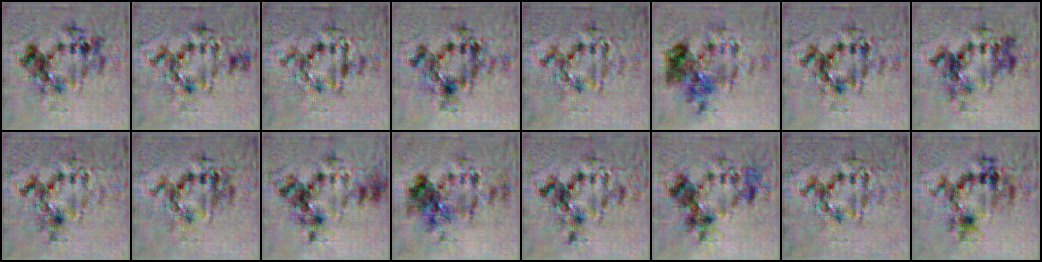

In [158]:
to_pil_grid(recon2.detach().cpu())

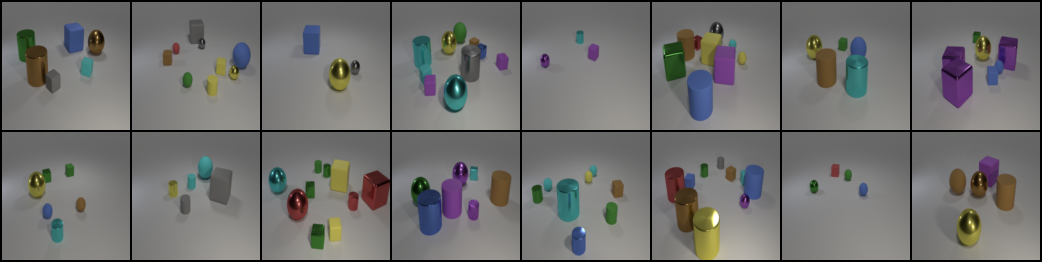

In [159]:
to_pil_grid(inp.detach().cpu())

In [66]:
def sample_objects_and_get_complement(probs=None, logits=None, hard=True, k=10):
    sample, _ = ssv.sample_bernoulli(logits=logits, probs=probs)
    (
        (topk_p_values, topk_p_indices),
        topk_complement,
    ) = ssv.get_topk_and_complement_indices(sample, k)
    if hard:
        topk_p_values = ssv.st_trick(topk_p_values)
    return topk_p_values, topk_p_indices, (probs or logits)[topk_complement].view(sample.size(0), -1)

In [30]:
from torch.autograd import grad

In [41]:
vpnet.zero_grad()
generator.zero_grad()

noise = torch.empty_like(inp).normal_(0, 0.01)
out = vpnet(inp + noise)
real_is_real = out[0]['is_real']
vp = vpnet.compute_vp_pred(out[1])

azimuth = vp['a'].unsqueeze(-1)
scale = out[0]['scale']
tx, tz = out[0]['txtz'].chunk(2, -1)
elevation = tilt = ty = torch.zeros_like(azimuth)
fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
z_fg = out[0]['z_fg']
fg_presence = out[0]['topk_p_values']
# pondered_z_fg = z_fg * fg_presence.unsqueeze(-1)
bottom_p = out[0]['presence_bottom'].mean()
z_bg = out[0]['z_bg']

recon = generator(z_bg, z_fg, view_in_fg=fg_view)
# recon2 = generator(z_bg.detach(), z_fg.detach(), view_in_fg=view_in_fg.detach())

grad(recon.sum(), generator.parameters())

(tensor([[[[[-7.8115e-02, -3.8539e-02, -2.2529e-02, -1.2279e-01],
            [ 5.0287e-02,  2.3360e-02, -3.2775e-01,  2.6285e-02],
            [-3.0355e-02,  9.2805e-02, -2.3639e-01, -3.6875e-02],
            [ 2.2252e-01,  6.9392e-02,  1.7143e-02, -1.3025e+00]],
 
           [[-3.3980e-02,  3.4460e-01, -2.3294e-02,  4.4876e-02],
            [-6.1916e-01, -1.5864e-01,  8.7758e-03,  2.0915e-01],
            [ 1.6150e-01, -9.4165e-02, -3.4997e-02,  4.0981e-01],
            [ 1.4077e-01, -2.6773e-01, -5.4509e-01,  7.6180e-01]],
 
           [[ 6.3412e-02,  8.9687e-02, -5.3550e-01,  6.5718e-02],
            [-1.1616e-01,  2.0568e-01, -1.2190e+00, -1.0098e-02],
            [ 2.5857e-02, -2.2171e-02,  1.1082e-01,  2.8641e-01],
            [ 4.6055e-01,  2.0013e-01, -3.3838e-02,  3.5143e-01]],
 
           [[ 4.3470e-02,  7.8539e-02,  8.1572e-01,  1.6175e-02],
            [ 9.6690e-02,  2.5911e-01, -1.2663e-01, -6.0602e-04],
            [ 1.0870e-01,  2.7571e-01,  2.1512e-01, -3.8065e-01],
 

In [42]:
list(vpnet.parameters())[0].grad, list(generator.parameters())[0].grad

(None, None)

In [ ]:
def phase1(inp, disc, generator, add_noise=True):
    disc.zero_grad()
    generator.zero_grad()
    
    if add_noise:
        d_inp = inp + torch.empty_like(inp)._normal(0, 0.01)
    else:
        d_inp = inp
    out = disc(d_inp)
    real_is_real = out[0]['is_real']
    vp = vpnet.compute_vp_pred(out[1])
    
    azimuth = vp['a'].unsqueeze(-1)
    scale = out[0]['scale']
    tx, tz = out[0]['txtz'].chunk(2, -1)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    z_fg = out[0]['z_fg']
    fg_presence = out[0]['topk_p_values']
    # pondered_z_fg = z_fg * fg_presence.unsqueeze(-1)
    bottom_p = out[0]['presence_bottom'].mean()
    z_bg = out[0]['z_bg']
    
    recon = generator(z_bg, z_fg, view_in_fg=view_in_fg) # for reconstruction loss
    
    recon2 = generator(z_bg.detach(), z_fg.detach(), view_in_fg=view_in_fg.detach()) # for gan and params loss
    out2 = disc(recon2)
    
    

In [43]:
out

(OrderedDict([('topk_p_values',
               tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0',
                      grad_fn=<AddBackward0>)),
              ('topk_p_indices',
               tensor([[60, 12, 48, 57,  9, 59, 62, 25,  2, 47]], device='cuda:0')),
              ('presence',
               tensor([[0.3191, 0.2751, 0.4552, 0.4179, 0.2156, 0.3146, 0.0842, 0.2058, 0.7623,
                        0.8995, 0.3590, 0.5527, 0.7961, 0.6194, 0.1722, 0.2054, 0.0590, 0.8562,
                        0.1792, 0.1763, 0.4732, 0.2039, 0.0550, 0.3079, 0.3160, 0.8007, 0.7320,
                        0.6321, 0.6107, 0.3994, 0.0928, 0.2245, 0.1602, 0.1074, 0.1552, 0.4095,
                        0.4970, 0.3640, 0.4672, 0.5888, 0.2391, 0.1998, 0.1926, 0.5712, 0.4219,
                        0.6789, 0.4246, 0.3381, 0.6399, 0.1917, 0.1991, 0.5526, 0.6805, 0.2457,
                        0.5493, 0.4466, 0.5592, 0.5382, 0.1629, 0.1754, 0.4537, 0.5787, 0.6453,
                    

In [9]:
n_steps = 1000
pbar = tqdm(range(n_steps))

loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
(inp,), targets, lengths = batch = next(iter(loader))
inp = inp.to(device)

vpnet = VPNet(instance_norm=True).to(device)
generator = Generator().to(device)
vpnet_pred_opt = torch.optim.Adam(vpnet.parameters(), lr=1e-4)
vpnet_disc_opt = torch.
g_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss(reduction='none')

for i in pbar:
    
    
    
    
    
    noise = torch.empty_like(inp).normal_(0, 0.01)
    out = vpnet(inp + noise)
    vp = vpnet.compute_vp_pred(out[1])
    
    real_is_real = out[0]['is_real']
    
    azimuth = vp['a'].unsqueeze(-1)
    scale = out[0]['scale']
    tx, tz = out[0]['txtz'].chunk(2, -1)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)

    z_fg = out[0]['z_fg']
    fg_presence = out[0]['topk_p_values']
    pondered_z_fg = z_fg * fg_presence.unsqueeze(-1)
    bottom_p = out[0]['presence_bottom'].mean()

    z_bg = out[0]['z_bg']
    recon = generator(z_bg.detach(), pondered_z_fg.detach(), view_in_fg=fg_view.detach())
    
    noise = torch.empty_like(inp).normal_(0, 0.01)
    fake_out = vpnet(recon.detach() + noise)
    fake_is_real = fake_out[0]['is_real']
    
    d_loss = discriminator_loss(real_is_real, fake_is_real)
    d_loss.backward()
    nn.utils.clip_grad_norm_(vpnet.parameters(), 1)
    d_opt.step()
    d_opt.zero_grad()
    
    #### END DISCRIMINATOR TRAIN
    ### BEGIN GENERATOR TRAIN
    
    noise = torch.empty_like(inp).normal_(0, 0.01)
    out = vpnet(inp + noise)
    vp = vpnet.compute_vp_pred(out[1])    
    azimuth = vp['a'].unsqueeze(-1)
    scale = out[0]['scale']
    tx, tz = out[0]['txtz'].chunk(2, -1)
    elevation = tilt = ty = torch.zeros_like(azimuth)
    fg_view = torch.cat((azimuth, elevation, tilt, scale, scale, scale, tx, ty, tz), -1)
    z_fg = out[0]['z_fg']
    fg_presence = out[0]['topk_p_values']
    pondered_z_fg = z_fg * fg_presence.unsqueeze(-1)
    bottom_p = out[0]['presence_bottom'].mean()
    z_bg = out[0]['z_bg']
    
    recon = generator(z_bg, pondered_z_fg, view_in_fg=fg_view)
    noise = torch.empty_like(inp).normal_(0, 0.01)
    fake_out = vpnet(recon + noise)
    fake_is_real = fake_out[0]['is_real']
    
    g_loss = generator_loss(fake_is_real)
    g_loss.backward()
    nn.utils.clip_grad_norm_(vpnet.parameters(), 1)
    nn.utils.clip_grad_norm_(generator.parameters(), 1)
    g_opt.step()
    d_opt.step()
    g_opt.zero_grad()
    d_opt.zero_grad()

    pbar.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item(), topk_pres=fg_presence.mean().item(), bottom_p=bottom_p.item())

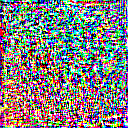

In [10]:
to_pil_grid(recon.detach().cpu())

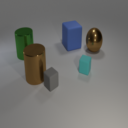

In [11]:
to_pil_grid(inp.cpu())

In [78]:
out

(OrderedDict([('topk_p_values',
               tensor([[0.8595, 0.8402, 0.8275, 0.8165, 0.7864, 0.7805, 0.7561, 0.7470, 0.6795,
                        0.6632],
                       [0.9452, 0.9090, 0.8383, 0.7658, 0.7621, 0.7311, 0.6994, 0.6991, 0.6973,
                        0.6750]], device='cuda:0', grad_fn=<TopkBackward>)),
              ('topk_p_indices',
               tensor([[43, 24, 16,  9, 53,  2, 17, 63, 44, 32],
                       [16,  8, 25, 24,  9, 45, 17, 61, 10, 53]], device='cuda:0')),
              ('presence',
               tensor([[0.5391, 0.5886, 0.7805, 0.4244, 0.3876, 0.4647, 0.1377, 0.2066, 0.6498,
                        0.8165, 0.5657, 0.2195, 0.0755, 0.2360, 0.2680, 0.3703, 0.8275, 0.7561,
                        0.3740, 0.5797, 0.3783, 0.0268, 0.6293, 0.4941, 0.8402, 0.5225, 0.3641,
                        0.4550, 0.4148, 0.2801, 0.3751, 0.5064, 0.6632, 0.4243, 0.3613, 0.1927,
                        0.5459, 0.3389, 0.3399, 0.1483, 0.5898, 0.3468, 